In [1]:
import numpy as np
import timeit
import os
import ctypes
import numba as nb
import matplotlib.pyplot as plt

In [2]:
all_mehods = []

In [3]:
def EratosthenesSievePurePython(n):
    nbs = [True] * (n+1)
    nbs[0] = False
    nbs[1] = False
    for i in range(2, int(n**0.5)+1):
        if nbs[i]:
            for j in range(i*i, n+1, i):
                nbs[j] = False
    return [i for i in range(n+1) if nbs[i]]

all_mehods.append({
    'method': 'Pure Python',
    'func': EratosthenesSievePurePython,
    'times': []
})

# quick test:
p = EratosthenesSievePurePython(100)
print(*p, sep=', ')

2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97


In [4]:
def EratosthenesSieveNumpy(n):
    nbs = np.ones(n+1, dtype=bool)
    nbs[:2] = 0
    for i in range(2, int(n**0.5)+1):
        if nbs[i]:
            for j in range(i*i, n+1, i):
                nbs[j] = 0
    return np.where(nbs)[0]

all_mehods.append({
    'method': 'Numpy',
    'func': EratosthenesSieveNumpy,
    'times': []
})

# quick test:
p = EratosthenesSieveNumpy(100)
print(*p, sep=', ')

2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97


In [5]:
def EratosthenesSieveFullNumpy(n):
    nbs = np.ones(n+1, dtype=bool)
    nbs[:2] = 0
    for i in range(2, int(n**0.5)+1):
        if nbs[i]:
            nbs[i*i::i] = 0
    return np.where(nbs)[0]

all_mehods.append({
    'method': 'Full Numpy',
    'func': EratosthenesSieveFullNumpy,
    'times': []
})

# quick test:
p = EratosthenesSieveFullNumpy(100)
print(*p, sep=', ')

2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97


In [6]:
@nb.jit(nopython=True)
def EratosthenesSieveNumba(n):
    nbs = np.ones(n+1, dtype=np.bool_)
    nbs[:2] = False
    for i in range(2, int(n**0.5)+1):
        if nbs[i]:
            for j in range(i*i, n+1, i):
                nbs[j] = False
    return np.where(nbs)[0]

all_mehods.append({
    'method': 'Numba',
    'func': EratosthenesSieveNumba,
    'times': []
})

# quick test:
p = EratosthenesSieveNumba(100)
print(*p, sep=', ')

2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97


In [7]:
# compiled functions
gcc_path = "C:\\__APP__\\mingw64\\bin\\gcc"
current_path = os.getcwd()

options = ['-O0', '-O1', '-O2', '-O3', '-Os', '-Ofast', '-Og', '-Oz']
EratostheneSieve_libs = []


# Define the Result struct in Python using ctypes
class Result(ctypes.Structure):
    _fields_ = [('primes', ctypes.POINTER(ctypes.c_int)), ('size', ctypes.c_int)]


compilation_times = {}
for opt in options:
    t = timeit.timeit(lambda: os.system(f'{gcc_path} -shared {opt} -o EratosthenesSieve{opt}.so EratosthenesSieve.c'), number=1)
    if t<0.5:
        repeat = int(0.5/t)+1
        final_t = timeit.timeit(lambda: os.system(f'{gcc_path} -shared {opt} -o EratosthenesSieve{opt}.so EratosthenesSieve.c'), number=repeat)/repeat
    else:
        repeat = 1
        final_t = t
    compilation_times[opt] = final_t
    
    os.system(f'{gcc_path} -shared {opt} -o EratosthenesSieve{opt}.so EratosthenesSieve.c')
    lib = ctypes.cdll.LoadLibrary(os.path.join(current_path, f'EratosthenesSieve{opt}.so'))
    lib.EratosthenesSieveC.restype = Result
    EratostheneSieve_libs.append(lib)


def EratosthenesSieveC(n, lib):
    result = lib.EratosthenesSieveC(n)
    return result.primes[:result.size]

all_mehods.append({
    'method': 'C -O0',
    'func': lambda n: EratosthenesSieveC(n, lib=EratostheneSieve_libs[0]),
    'times': []
})
all_mehods.append({
    'method': 'C -O1',
    'func': lambda n: EratosthenesSieveC(n, lib=EratostheneSieve_libs[1]),
    'times': []
})
all_mehods.append({
    'method': 'C -O2',
    'func': lambda n: EratosthenesSieveC(n, lib=EratostheneSieve_libs[2]),
    'times': []
})
all_mehods.append({
    'method': 'C -O3',
    'func': lambda n: EratosthenesSieveC(n, lib=EratostheneSieve_libs[3]),
    'times': []
})
all_mehods.append({
    'method': 'C -Os',
    'func': lambda n: EratosthenesSieveC(n, lib=EratostheneSieve_libs[4]),
    'times': []
})
all_mehods.append({
    'method': 'C -Ofast',
    'func': lambda n: EratosthenesSieveC(n, lib=EratostheneSieve_libs[5]),
    'times': []
})
all_mehods.append({
    'method': 'C -Og',
    'func': lambda n: EratosthenesSieveC(n, lib=EratostheneSieve_libs[6]),
    'times': []
})
all_mehods.append({
    'method': 'C -Oz',
    'func': lambda n: EratosthenesSieveC(n, lib=EratostheneSieve_libs[7]),
    'times': []
})

print('Compilation times:')
for opt, t in compilation_times.items():
    print(f'{opt}: {t:.3f} s')

# quick test:
p = EratosthenesSieveC(100, lib=EratostheneSieve_libs[0])
print(*p, sep=', ')

Compilation times:
-O0: 0.280 s
-O1: 0.375 s
-O2: 0.410 s
-O3: 0.454 s
-Os: 0.378 s
-Ofast: 0.392 s
-Og: 0.363 s
-Oz: 0.388 s
2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97, 0


In [8]:
os.system('python setup.py build_ext --inplace')

import EratosthenesSieveCython

all_mehods.append({
    'method': 'Cython',
    'func': EratosthenesSieveCython.EratosthenesSievePython,
    'times': []
})

# quick test:
p = EratosthenesSieveCython.EratosthenesSievePython(100)
print(*p, sep=', ')

2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97


In [9]:
all_mehods

[{'method': 'Pure Python',
  'func': <function __main__.EratosthenesSievePurePython(n)>,
  'times': []},
 {'method': 'Numpy',
  'func': <function __main__.EratosthenesSieveNumpy(n)>,
  'times': []},
 {'method': 'Full Numpy',
  'func': <function __main__.EratosthenesSieveFullNumpy(n)>,
  'times': []},
 {'method': 'Numba',
  'func': CPUDispatcher(<function EratosthenesSieveNumba at 0x000002A4732FFE20>),
  'times': []},
 {'method': 'C -O0', 'func': <function __main__.<lambda>(n)>, 'times': []},
 {'method': 'C -O1', 'func': <function __main__.<lambda>(n)>, 'times': []},
 {'method': 'C -O2', 'func': <function __main__.<lambda>(n)>, 'times': []},
 {'method': 'C -O3', 'func': <function __main__.<lambda>(n)>, 'times': []},
 {'method': 'C -Os', 'func': <function __main__.<lambda>(n)>, 'times': []},
 {'method': 'C -Ofast', 'func': <function __main__.<lambda>(n)>, 'times': []},
 {'method': 'C -Og', 'func': <function __main__.<lambda>(n)>, 'times': []},
 {'method': 'C -Oz', 'func': <function __mai

In [10]:
%%timeit
EratosthenesSievePurePython(1000000)

221 ms ± 13.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%%timeit
EratosthenesSieveNumpy(1000000)

357 ms ± 60.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
%%timeit
EratosthenesSieveFullNumpy(1000000)

4.6 ms ± 399 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
%%timeit
EratosthenesSieveNumba(1000000)

5.52 ms ± 357 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
%%timeit
EratosthenesSieveC(1000000, lib=EratostheneSieve_libs[0])

19.6 ms ± 660 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [15]:
%%timeit
EratosthenesSieveC(1000000, lib=EratostheneSieve_libs[1])

10.4 ms ± 507 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
%%timeit
EratosthenesSieveCython.EratosthenesSievePython(1000000)

98.5 ms ± 5.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
print('Speed Tests:')
for i in range(1,9):
    n = 10**i
    print(f'Taille 10^{i}:')
    for method in all_mehods:
        if i > 7 and method['method'] == 'Pure Python':
            continue
        if i > 7 and method['method'] == 'Numpy':
            continue
        if i > 7 and method['method'] == 'Cython':
            continue
        func = method['func']
        t = timeit.timeit(lambda: func(n), number=1)
        if t<0.5:
            repeat = int(0.5/t)+1
            final_t = timeit.timeit(lambda: func(n), number=repeat)/repeat
        else:
            repeat = 1
            final_t = t
        method['times'].append(final_t)
        print(f'\t{method["method"]}: {final_t:0.7f}s (repeats: {repeat})')

Speed Tests:
Taille 10^1:
	Pure Python: 0.0000039s (repeats: 26882)
	Numpy: 0.0000120s (repeats: 8334)
	Full Numpy: 0.0000082s (repeats: 14451)
	Numba: 0.0000015s (repeats: 36765)
	C -O0: 0.0000017s (repeats: 34014)
	C -O1: 0.0000015s (repeats: 72464)
	C -O2: 0.0000017s (repeats: 58140)
	C -O3: 0.0000017s (repeats: 42373)
	C -Os: 0.0000015s (repeats: 57472)
	C -Ofast: 0.0000014s (repeats: 75757)
	C -Og: 0.0000014s (repeats: 49020)
	C -Oz: 0.0000014s (repeats: 76924)
	Cython: 0.0000011s (repeats: 62500)
Taille 10^2:
	Pure Python: 0.0000135s (repeats: 28410)
	Numpy: 0.0000204s (repeats: 9452)
	Full Numpy: 0.0000102s (repeats: 21835)
	Numba: 0.0000016s (repeats: 34966)
	C -O0: 0.0000030s (repeats: 33113)
	C -O1: 0.0000023s (repeats: 70424)
	C -O2: 0.0000022s (repeats: 47170)
	C -O3: 0.0000023s (repeats: 33558)
	C -Os: 0.0000024s (repeats: 64103)
	C -Ofast: 0.0000022s (repeats: 43104)
	C -Og: 0.0000023s (repeats: 50506)
	C -Oz: 0.0000038s (repeats: 37038)
	Cython: 0.0000048s (repeats: 3030

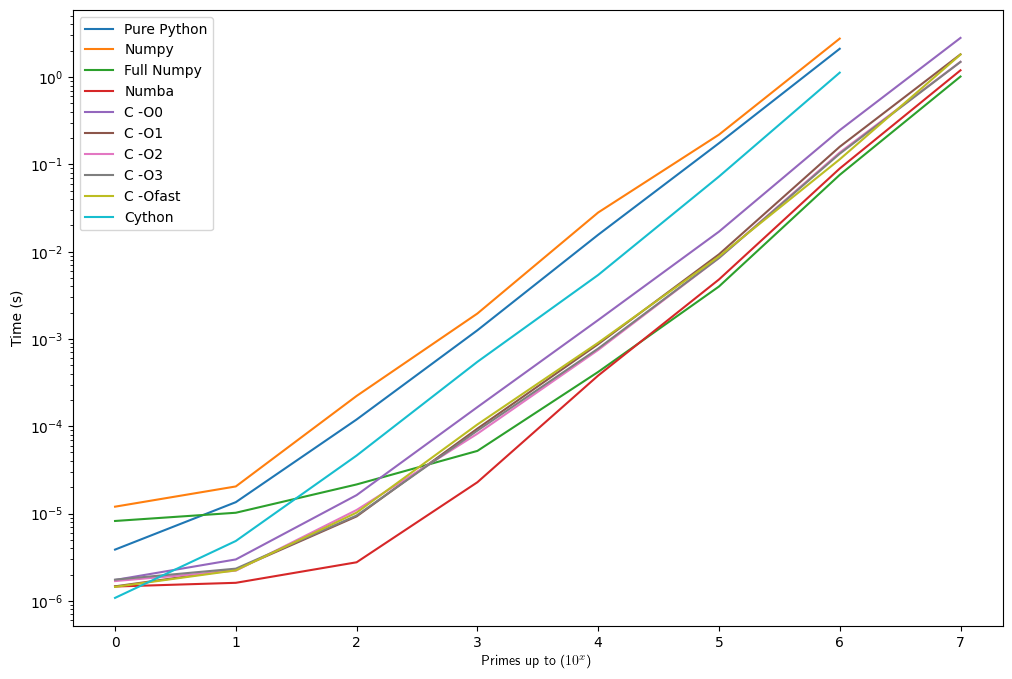

In [18]:
to_ignore = ['C -Oz', 'C -Os', 'C -Og']
plt.figure(figsize=(12, 8))
for method in all_mehods:
    if method['method'] in to_ignore:
        continue
    plt.semilogy(method['times'], label=method['method'])
plt.legend()
plt.xlabel('Primes up to ($10^x$)', usetex=True)
plt.ylabel('Time (s)')
plt.show()